# Open Street Map - *Graphs*

## What is a graph?
Well, before we start, let us talk about what s graph actually is, therefore we need to do some theory.  
In general: **A graph represents a set of objects and their relationships (relation).**
Components you require for a graph are: **vertex** and **edge**. Using these two elements one can create polygons, corners, etc. Connecting vertexes using edges creates your graph. Additionally, vertexes and edges can have a weight, to provide them a *cost* or a *weight*. This is used when different ways are existing, and you need to figure out what is the best one (for example when calculating the best way to walk from a to b and there are two ways, but one is much longer than the other, or one it less easy to walk than the other, etc.).  
<div>
<img src="./img/graph-basic.png" width="500"/>
</div>

**The formal definition**:  
A graph G is a pair (V, E) with the following properties:
1. V is a finite, non-empty set (elements of this set are called nodes).
2. E ⊆ V × V describes the set of edges.

## Example algorithms for graph processing and network analysis
Well, there are some algorithms to further categorize and process a graph. The algorithms, we present here, are focusing on subgraph identification and processing. So let us start with the first one for identifying a *connected subgraph* within a graph.

### Connected subgraph algorithm
In general, on top of a network data model, more network analysis functions can be implemented. One of them is finding specific subgraphs, such as for example which nodes can be reached starting at a specific point. This subgraph, finding all reachable nodes starting from a specific point, is called *connected subgraph*. The figure below shows reachable nodes starting from node **v2**. As you can see, the node **v6** is **not reachable**.
<div>
<img src="./img/graph-subgraph.png" width="700"/>
</div>

### Minimum spanning tree algorithm
Another network analysis operation is finding the *minimum spanning tree*, which is the spanning tree with the minimum sum of edge weights. Take a look at the following figure, each edge has a value here. **a)** is the original graph, **b)** is the minimal spanning tree, because there are not just no cycles left, but adding all costs together is **= 14**, which is the lowest possible value. **c)** is also a spanning tree, but not the minimal one, because all cost values together are 20, which is **> 14**.
<div>
<img src="./img/graph-cost.png" width="1000"/>
</div>

### Shortest path algorithm
One of the most important network operations is called *shortest path*. Here, the path with the lowest costs between two nodes is calculated. But what means *the lowest costs*? Well, every edge can have a value, this value defines the cost. A value could be the length of an edge, for example. We just used a method for calculating the shortest path between two places, which are (in our graph) represented as points. The method we used is based on the *Dijkstra Algorithm*.  
[Dijkstra algorithm](https://de.wikipedia.org/wiki/Dijkstra-Algorithmus#:~:text=Der%20Algorithmus%20von%20Dijkstra%20(nach,Pfade%20f%C3%BCr%20einen%20gegebenen%20Startknoten.) is better explained watching a video, search for Dijykstra on YouTube, there are a lot of tutorials. When we calculated the shorted path between *Reiff Museum* and *Aachen central station* in the method *.shorted_path()*, we actually use the Dijkstra algorithm.


Of course. these algorithms are not the only ones, we just want to show you a selection of important algorithms for graph processing and network analysis.

## Working with graphs
Spatial graphs can be traceable to a mathematical concept. A mathematical graph is composed of **nodes** which are linked by **edges**. Therefore, nodes can represent geographic places with specific locations and edges represent connecting paths. The composition is needed to analyse structures, such as the following example of path calculation shows.

In [1]:
import sys
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import LineString
from shapely.geometry import Point
from shapely.geometry import Polygon

%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.1.0'

In [2]:
point = (50.775593, 6.082478)

In [3]:
#Quering the exact geopoint of the two places in Aachen
reiff = ox.geocode("reiff museum aachen")
hbf = ox.geocode("Aachen Hauptbahnhof")

In [4]:
#Attention, getting the whole of Aachen takes many minutes, we will get the inner city only
G = ox.graph_from_point(point, dist=500, network_type="walk")

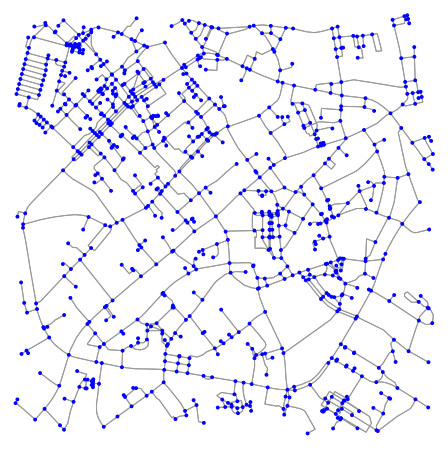

In [5]:
# Let us get out our graph from OSM first
ax, fig = ox.plot_graph(G, node_color='b', node_zorder=3, bgcolor='#FFFFFF')

In the following, we are going to plot the shortest path between a start and an end point. There is one issue, the actual train station is not part of the map itself, so the closest point to the train station is chosen. If you pick two nodes, then the shortest path between those two can be found, using weight = *length*. One-way streets are correctly handled.

In [6]:
#Set start and end point (value)
start = ox.nearest_nodes(G, reiff[1], reiff[0])
dest  = ox.nearest_nodes(G, hbf[1], hbf[0])

The **shortes_path()** function comes from the *NetworX* library. If the weight parameter of this function is specified, the Dijkstra's algorithm is used to find the optimal route. This algorithm belongs to the class of Greedy algorithms. In graph theory, these are used to solve optimization problems such as finding the shortest path.

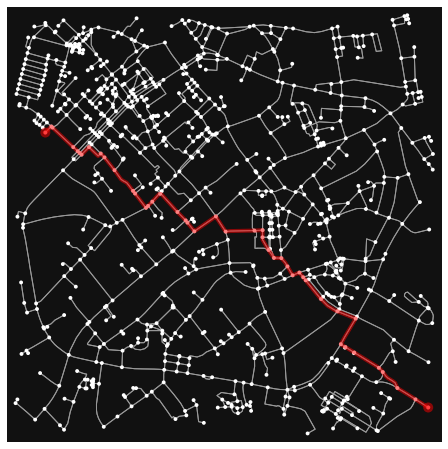

<Figure size 432x288 with 0 Axes>

In [7]:
#Calculate the shortest path between start and end point
route = ox.shortest_path(G, start, dest)
ox.plot_graph_route(G, route)
import matplotlib.pyplot as plt
plt.savefig('world.jpg')

# Isochrone map using OSM data
So far so good, let us look at a more advanced example by using OSM data to analyse information about speed and travel time. The following code is mainly done by Geoff Boeing this is one of his examples, we have adapted it to Aachen. He developed *OSMnx*!  
## Isochrone map
This sort of map depicts the area accessible from a point within a certain time threshold (iso= equal, chrone= time). It is common in geography and urban planning, and we can create one using OSM data and Python package *OSMnx*. But let us start with importing the necessary libraries.

## Querying a places' data
The function graph_from_place can only be used for areas where the query must be geocodable and OSM must have polygon boundaries for the result. Alternatively, use the **graph_from_address** function. Here, the geocode converts the place name to a point.

In [8]:
#Set needed values for parameter
place = "Templergraben 55, Aachen, Germany"
network_type = "walk"
dist = 1000
trip_times = [5, 10, 15, 20]
travel_speed = 4.5 #walking speed in km/hour

In [9]:
G = ox.graph_from_address(place, dist=dist, network_type=network_type)

In [10]:
#Find the centermost node and then project the graph to UTM
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes["geometry"].unary_union.centroid.xy
center_node = ox.nearest_nodes(G, x[0], y[0])
G = ox.project_graph(G)

## Calculations

In [11]:
#Add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
for _, _, _, data in G.edges(data=True, keys=True):
    data["time"] = data["length"] / meters_per_minute

In [12]:
#Get the color
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="plasma", start=0, return_hex=True)

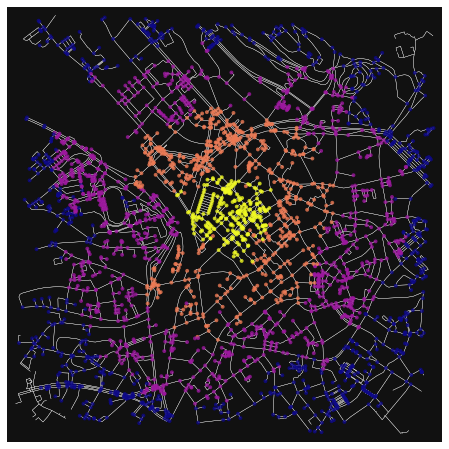

In [13]:
#Color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
#Define node color and size
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
#Plotting the graph
fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.3,
    edge_color="#ffffff",
)
fig.savefig('plot.png', dpi=300)

## Colouring: from point to area
So until now, we have got coloured points, but we would like to have polygons in our map. So what we do is, we take the nodes and calculate the polygon.

In [14]:
#Create the isochrone polygons
isochrone_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
    bounding_poly = gpd.GeoSeries(node_points).unary_union.convex_hull
    isochrone_polys.append(bounding_poly)

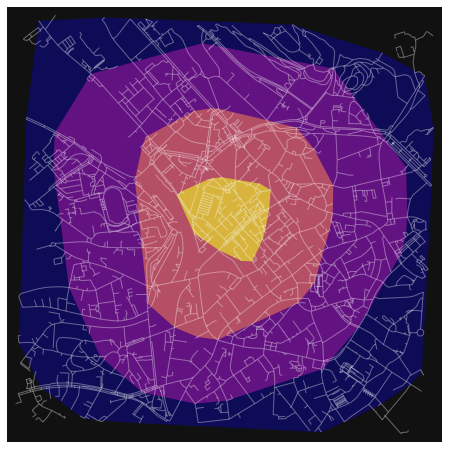

In [15]:
#Create graph plot
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#ffffff", edge_alpha=0.2, node_size=0
)
#Adding polygons
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.6, zorder=-1)
    ax.add_patch(patch)
plt.show()

## Shape the colouring
The next part is huge and contains mathematic. It is the first time we actually create a function. We want the polygon we already got to follow the street shape, therefore we need to do some reshaping. Go through the following code and try to understand what happens.

In [16]:
#Creating a function for polygon shaping
def make_iso_polys(G, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance="time")
        node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({"id": list(subgraph.nodes)}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index("id")

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get("geometry", LineString([f, t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).unary_union
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys

In [ ]:
isochrone_polys = make_iso_polys(G, edge_buff=25, node_buff=0, infill=True)
#Create the graph plot
fig, ax = ox.plot_graph(
    G, show=False, close=False, edge_color="#ffffff", edge_alpha=0.2, node_size=0
)
#Adding polygons
for polygon, fc in zip(isochrone_polys, iso_colors):
    patch = PolygonPatch(polygon, fc=fc, ec="none", alpha=0.7, zorder=-1)
    ax.add_patch(patch)
plt.show()

## Saving graphs to GeoPackage and SVG file
Sometimes you need this picture printed as PNG or JPG or a more geo related file such as GeoPackage.

In [18]:
ox.save_graph_geopackage(G, filepath="mynetwork.gpkg")

Or we could also save it as Shapefile:

In [19]:
ox.save_graph_shapefile(G, filepath="mynetwork.shp")

/opt/conda/lib/python3.9/site-packages/osmnx/io.py:108: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


When running the code above, you get a warning. This warning is not about something using Python but rather a specification about Shapefile. Shapefile uses the *dBASE* file format to store attribute information. Just remember the character limitation of field names.
Other times you may need your graphs to be able to load in for example illustrator and therefore saved as **svg** file. When running the code below, a new file will show up in your file structure, called mynetwork.svg.

In [20]:
ox.plot_graph_route(G, route, node_color='b', node_zorder=3, bgcolor='#FFFFFF', show=False, save=True, filepath='./mynetwork.svg')

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

### Exercise
Center your own living address and find out what is reachable using only bike network. Figure out what the average speed using a bike is and assume trip times in a range from 20 to 50 and use another colour map.